In [5]:
import numpy as np
import pandas as pd
from os import path
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch

In [22]:
# Check if GPU is available
torch.cuda.is_available()

True

In [2]:
# Load and preprocess data
training = pd.read_csv('training.csv')
testing = pd.read_csv('test.csv')

# Input -1 for missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)

# Convert back to dataframe and replace the missing values
training = pd.DataFrame(imputer.fit_transform(training), columns=training.columns)

# Extract target columns (first 30 columns for 15 keypoints)
y_training = training.iloc[:, :30]

# Get the last feature column
lastFeature = training.iloc[:, -1]

# Split the last feature by spaces
splitFeatures = lastFeature.str.split(' ', expand=True)

# Drop the original last feature and concatenate the new split features
training = pd.concat([training.drop(training.columns[-1], axis=1), splitFeatures], axis=1)

# Drop the first columns here so they aren't mislabeled, and this way we can just make this the X_train
training.drop(training.columns[range(0, 30)], axis=1, inplace=True)

# Rename the columns to pixel_i
training.columns = [f'pixel_{i}' for i in range(training.shape[1])]

# Same for testing
testImg = testing.iloc[:, -1]
splitTest = testImg.str.split(' ', expand=True)
testing = pd.concat([testing.drop(testing.columns[-1], axis=1), splitTest], axis=1)

# There was an extra column that was just the index
testing.drop(columns=testing.columns[[0]], inplace=True)

# Rename the columns to pixel_i
testing.columns = ['ImageId'] + [f'pixel_{i}' for i in range(1, testing.shape[1])]

# Split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(training, y_training, train_size=0.8, test_size=0.2, random_state=10)

# Reshape dataframe into numpy array so I can reshape it again
X_train = X_train.to_numpy(dtype=np.float32)

# Reshape image data so the model can process it as a Tensor
X_train = X_train.reshape(-1, 1, 96, 96)
X_train = X_train / 255.0

# Reshape y_train into a numpy array as well
y_train = np.array(y_train, dtype=np.float32)

# Reshape test data
X_test = X_test.to_numpy(dtype=np.float32)
X_test = X_test.reshape(-1, 1, 96, 96)
X_test = X_test / 255.0

y_test = np.array(y_test, dtype=np.float32)


In [32]:
class ImprovedCnnModel(nn.Module):
    def __init__(self):
        super(ImprovedCnnModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Adjusted for 96x96 input
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 30)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors and create DataLoader
xTrainTensor = torch.tensor(X_train.reshape(-1, 1, 96, 96), dtype=torch.float32)
yTrainTensor = torch.tensor(y_train, dtype=torch.float32)
trainDataset = TensorDataset(xTrainTensor, yTrainTensor)
trainLoader = DataLoader(trainDataset, batch_size=24, shuffle=True)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedCnnModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

modelPath = 'models/cnn100.pth'

# Loads the model if it exists, otherwise train it
if path.exists(modelPath):
    model.load_state_dict(torch.load(modelPath, weights_only=True))
else:
    numEpochs = 100
    for epoch in range(numEpochs):
        model.train()
        runningLoss = 0.0
        for inputs, targets in trainLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            runningLoss += loss.item()
        
        print(f'Epoch {epoch+1}/{numEpochs}, Loss: {runningLoss/len(trainLoader)}')
    # Save the model
    torch.save(model.state_dict(), modelPath)


In [33]:
# Evaluation
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 96, 96), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

y_pred = y_pred_tensor.cpu().numpy()
mse2 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse2}')

Mean Squared Error (MSE): 121.69734191894531


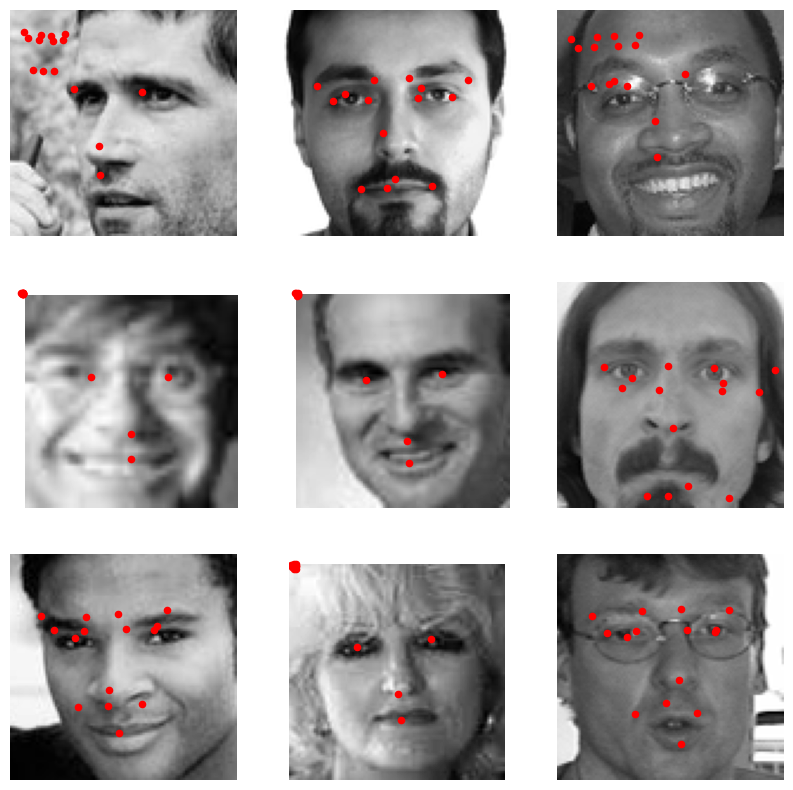

In [34]:
import matplotlib.pyplot as plt

def showPrediction(image, keypoints, size, idx): # Shows the image with the predicted keypoints
    plt.subplot(int(size ** 0.5), int(size ** 0.5), idx + 1)
    plt.imshow(image, cmap='gray')
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i], keypoints[i+1], c='red', s=20)
    plt.axis('off')

X_test = X_test.reshape(-1, 96, 96)

plt.figure(figsize=(10, 10))
for idx in range(20, 29):
    showPrediction(X_test[idx], y_pred[idx], 9, idx - 20)
plt.show()